# Un filtro de historieta

Para este ejemplo, vamos a crear un filtro que recibe una imagen y la transforma
de tal manera que parezca salida de una historieta.
La idea es detectar los bordes de la imagen para los contornos, un umbral para
la intensidad de los colores y una posterización para reducir la cantidad de
colores.

In [ ]:
kaggle datasets download -d ashwingupta3012/human-faces

In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import skimage as ski
from sklearn import cluster

Primero seleccionamos una imagen de prueba al azar para explicar este filtro.

In [2]:
DIR_IMAGENES = Path("Selfis")
ruta_imagen = random.choice(list(DIR_IMAGENES.glob("*.jpg")))
original = ski.util.img_as_float(ski.io.imread(ruta_imagen))

Para este cuaderno vamos a mostrar el proceso paso a paso, mostrando cada
resultado intermedio.
Para ello vamos a crear dos funciones auxiliares, una para mostrar la imagen
y otra para mostrar su histograma.

In [3]:
def mostrar_imagen(img, ax = None, titulo=None):
    if ax is None:
        ax = plt.gca()
    ski.io.imshow(img, ax=ax)
    ax.axis('off')
    if titulo is not None:
        ax.set_title(titulo)

def mostrar_histograma(img, ax = None, n_barras=256):
    if ax is None:
        ax = plt.gca()
    ax.hist(img.ravel(), bins=n_barras, histtype='stepfilled', color='black')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax.set_xlabel('Valor de píxel')
    ax.set_xlim(0, 1)
    ax.set_ylabel('Frecuencia')
    ax.spines[['top', 'right']].set_visible(False)

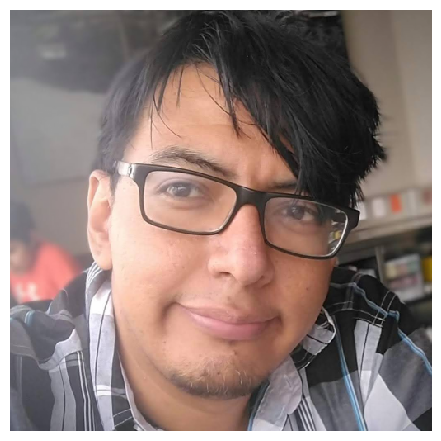

In [4]:
lado = 512

# Recortar a un cuadrado en caso de que la imagen no sea cuadrada.
alto, ancho = original.shape[:2]

if alto < ancho:
    alto, ancho = round(lado * alto / ancho), lado
elif alto > ancho:
    alto, ancho = lado, round(lado * ancho / alto)
else:
    alto, ancho = lado, lado

# Reescalar tamaño para facilitar el procesamiento.
original = ski.transform.resize(original, (alto, ancho))

mostrar_imagen(original)

Para comenzar, vamos a trabajar unicamente con la capa de luminancia de la
imagen, ya que es la que contiene la información de los bordes.

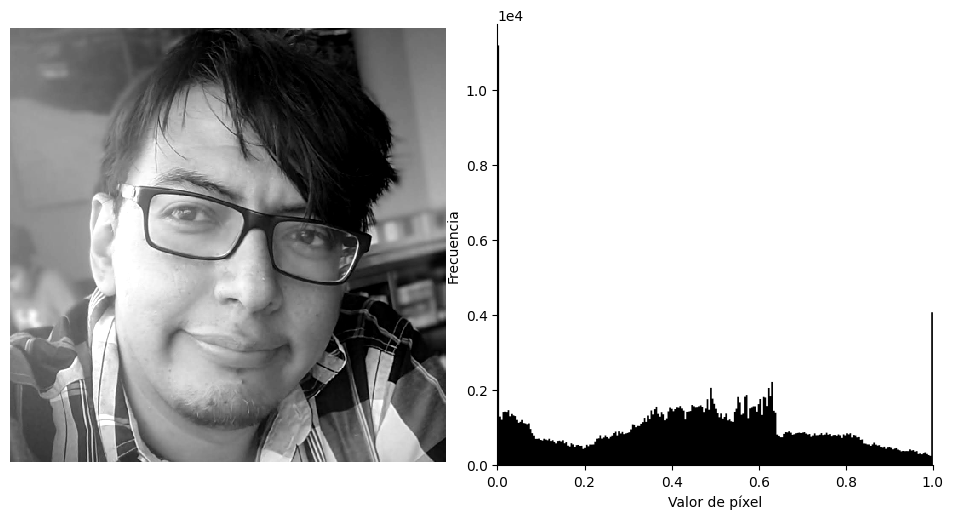

In [5]:
capa_luminosidad = ski.color.rgb2gray(original)
capa_luminosidad = ski.exposure.rescale_intensity(capa_luminosidad, in_range=(0.1, 0.9))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
mostrar_imagen(capa_luminosidad, axs[0])
mostrar_histograma(capa_luminosidad, axs[1])

Para identificar los bordes de la imagen, utilizamos la diferencia de la
imagen con una versión desenfocada de la misma, es decir, el filtro de
*diferencia de gaussianas*.
Este proceso produce una matriz con valores positivos y negativos, dependiendo
de la diferencia entre los píxeles vecinos.

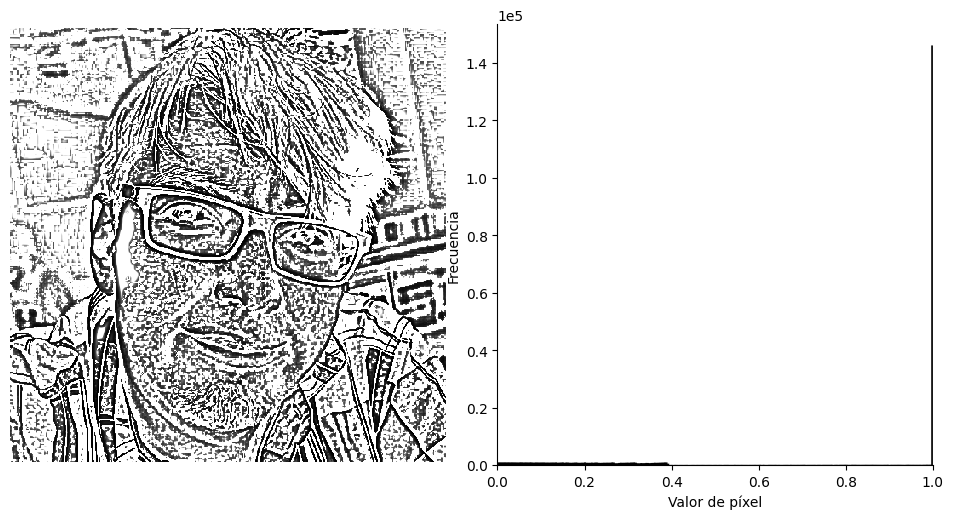

In [6]:
borde = 2

# Encontrar contornos mediante diferencia de gaussianas
capa_bordes = ski.filters.difference_of_gaussians(capa_luminosidad, 0, borde)
capa_bordes[capa_bordes < 0] = 0

# Invertir imagen
capa_bordes = 1 - capa_bordes
capa_bordes = ski.exposure.equalize_hist(capa_bordes)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
mostrar_imagen(capa_bordes, ax[0])
mostrar_histograma(capa_bordes, ax[1])

Como podemos apreciar, la capa de los bordes de la imagen contiene muchos
parásitos que no son bordes reales.
Estos parásitos se pueden eliminar utilizando un filtro de umbral.
Todos los valores por arriba de un cierto umbral se convierten en blanco.

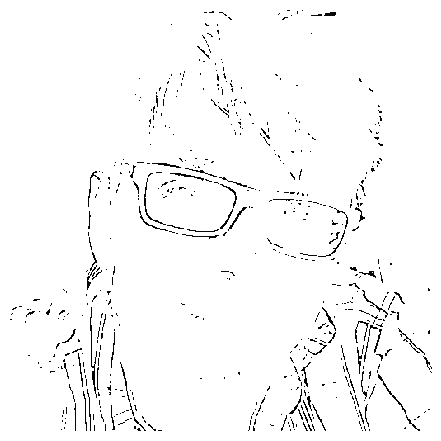

In [7]:
umbral_bordes = 0.05

capa_bordes[capa_bordes > umbral_bordes] = 1
capa_bordes = ski.filters.median(capa_bordes, footprint=np.ones((borde, borde)))

# Mostrar imagen
mostrar_imagen(capa_bordes)

A continuación, usamos un efecto de umbral para detectar las sombras de la
imagen.
Esto hace que las partes oscuras de la imagen se vuelvan completamente negras,
como hechas con tinta.

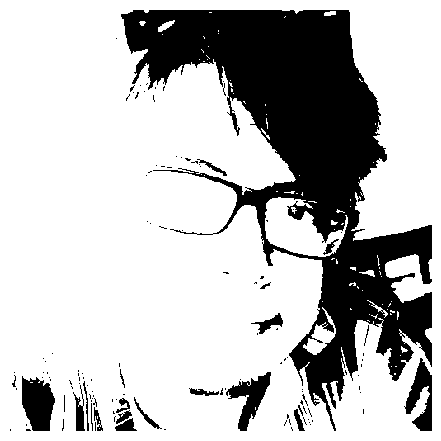

In [8]:
umbral_sombras = 0.3
capa_sombras = (capa_luminosidad >= umbral_sombras).astype(float)

mostrar_imagen(capa_sombras)

Ahora combinamos los bordes y las sombras para obtener una imagen B/N que
parece salida de una historieta.

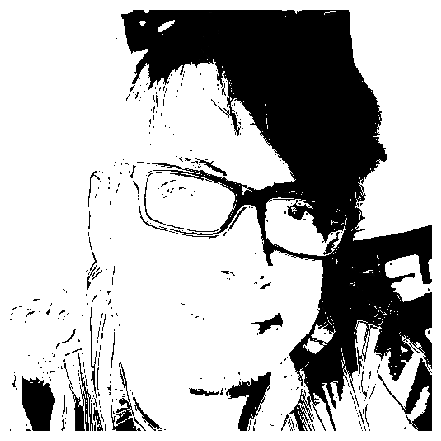

In [9]:
capa_tinta = capa_sombras * capa_bordes

mostrar_imagen(capa_tinta)

Ahora vamos a obtener una capa de tonos medios de la imagen original.

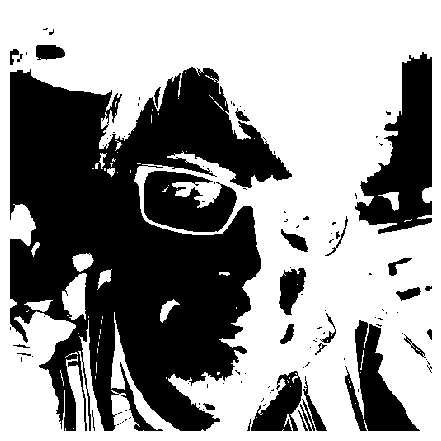

In [10]:
umbral_medio = 0.5
capa_medio_tono = (capa_luminosidad < umbral_medio).astype(float)

mostrar_imagen(capa_medio_tono)


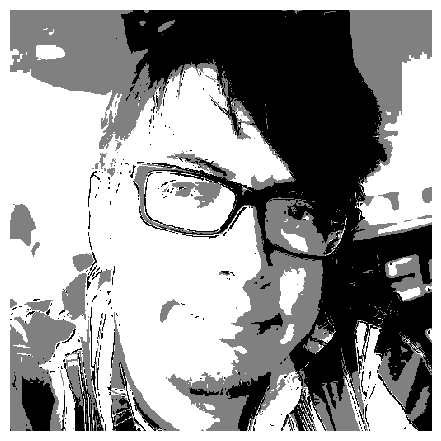

In [11]:
capa_tinta -= umbral_medio*capa_medio_tono
capa_tinta[capa_tinta < 0] = 0

mostrar_imagen(capa_tinta)

A continuación, vamos a reducir la cantidad de colores de la imagen.
Para ello usamos la técnica de *posterización* que vimos en clase con el
algo de las k-medias.

Dado que queremos tener un efecto colorido, el primer paso es aumentar la
saturación de la imagen.

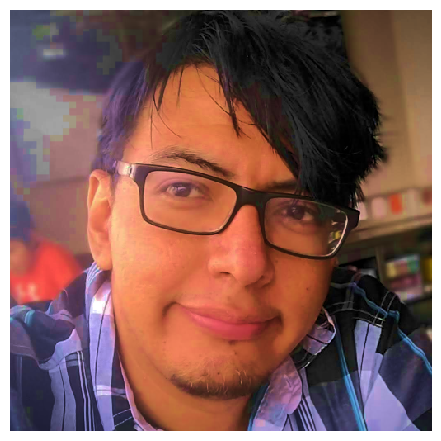

In [12]:
gamma_saturacion = 0.4

# Convertir la imagen al espacio de color HSV
capa_color = original.copy()
capa_color = ski.color.rgb2hsv(capa_color)

# Incrementar la saturación y ecualizar la luminancia
capa_color[:, :, 1] **= gamma_saturacion
capa_color[:, :, 2] = ski.exposure.equalize_hist(capa_color[:, :, 2])

capa_color = ski.color.hsv2rgb(capa_color)

mostrar_imagen(capa_color)

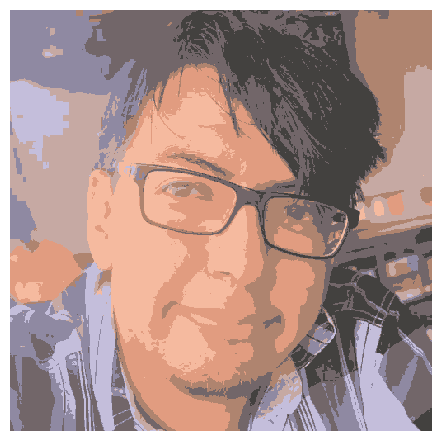

In [13]:
niveles = 8

# Posterizar
kmeans = cluster.KMeans(n_clusters=niveles)
X = capa_color.reshape(-1, 3)
kmeans.fit(X)
capa_color = kmeans.cluster_centers_[kmeans.labels_].reshape(capa_color.shape)

# Aplicar gamma
capa_color = ski.exposure.adjust_gamma(capa_color, gamma=0.5)

mostrar_imagen(capa_color)

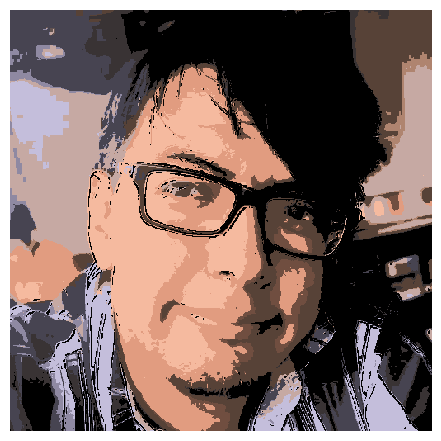

In [14]:
# Multiplicar cada capa de color RGB por la imagen de trazos
for ch in range(3):
    capa_color[..., ch] *= capa_tinta

mostrar_imagen(capa_color)

A continuación se muestra el código completo para aplicar este filtro a una
imagen.

In [15]:
class FiltroHistorieta:
    """
    Aplica un filtro de historieta a una imagen.

    Parámetros
    ----------
    borde : int
        Tamaño de los bordes.
    umbral_bordes : float
        Umbral para detectar bordes.
    umbral_sombras : float
        Umbral para detectar sombras.
    umbral_medio : float
        Umbral para detectar medio tono.
    gamma_saturacion : float
        Gamma para saturación.
    niveles : int
        Número de niveles para posterizar.

    Métodos
    -------
    aplicar(imagen: np.ndarray) -> np.ndarray
        Aplica el filtro a una imagen.
    """

    tamano = 512

    def __init__(
        self,
        *,
        borde=2,
        umbral_bordes=0.05,
        umbral_sombras=1 / 3,
        umbral_medio=0.5,
        gamma_saturacion=0.4,
        niveles=8,
    ):
        """
        Inicializa el filtro de historieta.

        Parámetros
        ----------
        borde : int
            Tamaño de los bordes.
        umbral_bordes : float
            Umbral para detectar bordes.
        umbral_sombras : float
            Umbral para detectar sombras.
        umbral_medio : float
            Umbral para detectar medio tono.
        gamma_saturacion : float
            Gamma para saturación.
        niveles : int
            Número de niveles para posterizar.
        """
        self.borde = borde
        self.umbral_bordes = umbral_bordes
        self.umbral_sombras = umbral_sombras
        self.umbral_medio = umbral_medio
        self.gamma_saturacion = gamma_saturacion
        self.niveles = niveles

    def aplicar(self, imagen: npt.NDArray[np.floating]) -> npt.NDArray[np.floating]:
        """
        Aplica el filtro de historieta a una imagen.

        Parámetros
        ----------
        imagen : np.ndarray
            Imagen de entrada.

        Retorna
        -------
        np.ndarray
            Imagen con filtro de historieta aplicado.
        """
        imagen = self._recortar(imagen)
        capa_luminosidad = self._extraer_luminosidad(imagen)
        capa_bordes = self._extraer_bordes(capa_luminosidad)
        capa_sombras = self._extraer_sombras(capa_luminosidad)
        capa_tinta = self._extraer_tinta(capa_luminosidad, capa_bordes, capa_sombras)
        capa_medio_tono = self._extraer_medio_tono(capa_luminosidad)
        capa_color = self._extraer_color(imagen, capa_medio_tono)
        resultado = self._aplicar_tinta(capa_color, capa_tinta)
        return resultado

    def _recortar(self, imagen: npt.NDArray[np.floating]) -> npt.NDArray[np.floating]:
        alto, ancho = imagen.shape[:2]
        if alto < self.tamano and ancho < self.tamano:
            return imagen

        if alto > ancho:
            alto, ancho = self.tamano, round(ancho * self.tamano / alto)
        elif alto < ancho:
            alto, ancho = round(alto * self.tamano / ancho), self.tamano
        else:
            alto, ancho = self.tamano, self.tamano

        return ski.transform.resize(imagen, (alto, ancho))

    def _extraer_luminosidad(
        self, imagen: npt.NDArray[np.floating]
    ) -> npt.NDArray[np.floating]:
        capa_luminosidad = ski.color.rgb2gray(imagen)
        capa_luminosidad = ski.exposure.rescale_intensity(
            capa_luminosidad, in_range=(0.1, 0.9)
        )
        return capa_luminosidad

    def _extraer_bordes(
        self, capa_luminosidad: npt.NDArray[np.floating]
    ) -> npt.NDArray[np.floating]:
        capa_bordes = ski.filters.difference_of_gaussians(
            capa_luminosidad, 0, self.borde
        )
        capa_bordes[capa_bordes < 0] = 0
        capa_bordes = 1 - capa_bordes
        capa_bordes = ski.exposure.equalize_hist(capa_bordes)
        capa_bordes[capa_bordes > self.umbral_bordes] = 1
        capa_bordes = ski.filters.median(
            capa_bordes, footprint=np.ones((self.borde, self.borde))
        )
        return capa_bordes

    def _extraer_sombras(
        self, capa_luminosidad: npt.NDArray[np.floating]
    ) -> npt.NDArray[np.floating]:
        capa_sombras = (capa_luminosidad >= self.umbral_sombras).astype(float)
        return capa_sombras

    def _extraer_tinta(
        self,
        capa_luminosidad: npt.NDArray[np.floating],
        capa_bordes: npt.NDArray[np.floating],
        capa_sombras: npt.NDArray[np.floating],
    ) -> npt.NDArray[np.floating]:
        capa_tinta = capa_sombras * capa_bordes
        capa_tinta -= self.umbral_medio * (
            (capa_luminosidad < self.umbral_medio).astype(float)
        )
        capa_tinta[capa_tinta < 0] = 0
        return capa_tinta

    def _extraer_medio_tono(
        self, capa_luminosidad: npt.NDArray[np.floating]
    ) -> npt.NDArray[np.floating]:
        capa_medio_tono = (capa_luminosidad < self.umbral_medio).astype(float)
        return capa_medio_tono

    def _extraer_color(
        self,
        imagen: npt.NDArray[np.floating],
        capa_medio_tono: npt.NDArray[np.floating],
    ) -> npt.NDArray[np.floating]:
        capa_color = imagen.copy()
        capa_color = ski.color.rgb2hsv(capa_color)
        capa_color[:, :, 1] **= self.gamma_saturacion
        capa_color[:, :, 2] = ski.exposure.equalize_hist(capa_color[:, :, 2])
        capa_color = ski.color.hsv2rgb(capa_color)
        kmeans = cluster.KMeans(n_clusters=self.niveles)
        kmeans.fit(capa_color.reshape(-1, 3))
        capa_color = kmeans.cluster_centers_[kmeans.labels_].reshape(capa_color.shape)
        capa_color = ski.exposure.adjust_gamma(capa_color, gamma=0.5)
        return capa_color

    def _aplicar_tinta(
        self,
        capa_color: npt.NDArray[np.floating],
        capa_tinta: npt.NDArray[np.floating],
    ) -> npt.NDArray[np.floating]:
        for ch in range(3):
            capa_color[..., ch] *= capa_tinta
        return capa_color

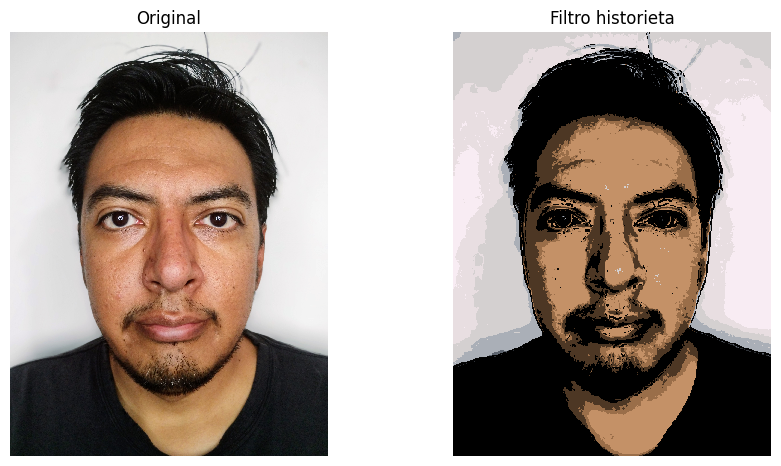

In [20]:
ruta_imagen = random.choice(list(DIR_IMAGENES.glob("*.jpg")))
original = ski.util.img_as_float(ski.io.imread(ruta_imagen))
filtro = FiltroHistorieta()
resultado = filtro.aplicar(original)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
mostrar_imagen(original, axs[0], "Original")
mostrar_imagen(resultado, axs[1], "Filtro historieta")